     pcost       dcost       gap    pres   dres
 0: -2.0636e+01 -4.3905e+01  3e+02  2e+01  2e+00
 1: -2.2372e+01 -3.7202e+01  9e+01  5e+00  5e-01
 2: -2.3112e+01 -3.8857e+01  5e+01  2e+00  2e-01
 3: -2.8318e+01 -3.3963e+01  1e+01  4e-01  4e-02
 4: -3.2264e+01 -3.3927e+01  2e+00  1e-02  1e-03
 5: -3.3568e+01 -3.3764e+01  2e-01  1e-03  1e-04
 6: -3.3737e+01 -3.3739e+01  2e-03  1e-05  1e-06
 7: -3.3739e+01 -3.3739e+01  2e-05  1e-07  1e-08
 8: -3.3739e+01 -3.3739e+01  2e-07  1e-09  1e-10
Optimal solution found.

 alphas are:
[1.16382858e-09 2.95760572e-09 4.32074218e-09 6.22950650e-10
 3.96514947e-10 3.30857663e-09 9.19717943e-10 2.29626616e-09
 4.68875042e-10 9.06704213e-10 2.99957260e-09 7.27109889e-10
 3.93650993e-10 6.72700268e-10 1.35673038e-09 6.95733506e-10
 8.35637235e-10 2.23121730e-09 2.00173857e-09 1.64450925e-09
 1.02886365e-09 1.13846035e-09 1.74476154e-08 2.90474061e-09
 1.50559512e-09 2.15214671e-07 2.39162813e-09 3.37387519e+01
 2.83079590e-09 2.38889285e-09 4.20905797e-10 

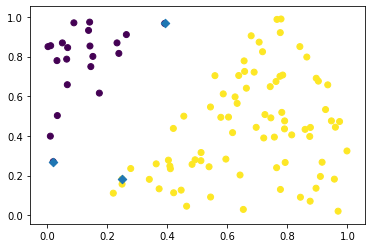

In [10]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
import sys
class SVM:

    def __init__(self, filename):
        self.dat = np.loadtxt(filename,dtype='float',delimiter=',')
        self.X = self.dat[:,0:2]
        self.Y = self.dat[:,2]
        self.rows, self.cols = self.X.shape
        self.omiga = 0.01
        self.hyperplane()
        self.support_vectors()
        self.weights()
        self.plot()
        # Need to get the intercept
        #self.kernel_function() --> create a kernel function for non linear data
        
    def hyperplane(self):
        self.xixj = np.zeros((self.rows, self.rows))
        self.yiyj = np.zeros((self.rows, self.rows))
        
        for i in range(self.rows):
            for j in range(self.rows):
                self.xixj[i, j] = np.dot(self.X[i], self.X[j])
                self.yiyj[i, j] = np.dot(self.Y[i], self.Y[j])

        P = self.yiyj * self.xixj
        q = np.ones(self.rows) * -1
        G = np.diag(np.ones(self.rows) * -1)
        h = np.zeros(self.rows)
        A = self.Y
        b = 0.0
        self.alphas = self.cvxopt_solve_qp(P, q, G, h, A, b)
        print('\n alphas are:')
        print(self.alphas)
        
    def cvxopt_solve_qp(self, P, q, G=None, h=None, A=None, b=None):
    #     P = .5 * (P + P.T)  # make sure P is symmetric
        args = [cvxopt.matrix(P), cvxopt.matrix(q)]
        if G is not None:
            args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
            if A is not None:
                args.extend([cvxopt.matrix(A, (1,100)), cvxopt.matrix(b)])
        sol = cvxopt.solvers.qp(*args)
        if 'optimal' not in sol['status']:
            return None
        return np.array(sol['x']).reshape((P.shape[1],))

    def quadprog_solve_qp(self, P, q, G=None, h=None, A=None, b=None):
        """This is a faster QPP method"""
#         qp_G = .5 * (P + P.T)# make sure P is symmetric
        qp_G = P
        qp_a = -q
        if A is not None:
            qp_C = -np.vstack([A, G]).T
            qp_b = -np.hstack([b, h])
            meq = A.shape[0]
        else:  # no equality constraint
            qp_C = -G.T
            qp_b = -h
            meq = 0
    #     print(quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0])
        return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]
    
    def support_vectors(self):
        self.sv_index = np.where(self.alphas>0.00001)[0]
        self.sv_x = self.X[self.sv_index]
        self.sv_y = self.Y[self.sv_index]
        print('\n Support Vectors are:')
        print(self.sv_x, self.sv_y)
        return(self.sv_index, self.sv_x, self.sv_y)

    def weights(self):
        self.weights = np.sum(self.alphas[self.sv_index][:, np.newaxis] * self.sv_y[:, np.newaxis] * self.sv_x, 0)[:, np.newaxis]
        print(f'\n weights: {self.weights}')
        return self.weights
    
    def plot(self):
        plt.scatter(self.X[:,0],self.X[:,1],c=self.Y)         
        plt.scatter(self.sv_x[:,0],self.sv_x[:,1], marker = 'D')
        plt.show()
        
    def _str__(self):
        return 'done'

filename = 'C:\\Users\\Peter\\Desktop\\Classes\\INF 552\\Homework 6\\linsep.txt'
p = SVM(filename)
print(p)